##Gráficas computacionales

Las gráficas computacionales modelan las variables y las operaciones entre variables para computar una función matemática. Su importancia es que en funciones compuestas que toman varios argumentos, como
(
f
1
∘
f
2
∘
⋯
∘
f
n
)
(
x
1
,
.
.
.
,
x
m
)
, pues dentro de la gráficas cada variable
x
i
 se asigna un valor, y cada nodo de la gráfica hace un cálculo por cada función
f
i
 para usar las salidas en funciones de mayor nivel.

 -------------------------------------------------

Otra aplicación de suma importancia de las gráficas computacionales es poder obtener las derivadas de estas funciones sobre distintas variables. De tal forma, que podemos recuperar el gradiente de la función.

---------------------------------------------------

Distinguimos dos tipos de gráficas computacionales:

Estáticas y Dinámicas

##Gráfica estática

En una gráfica estática, que construimos a partir de TensorFlow, definimos la gráfica usando para las variables el método de placeholder para indicar que serán nodos de entrada, y de qué tipo serán estos nodos (flotantes de 32 bits).

Ya que aquí los nodos para las entradas representan variables (no valores constantes con los que se puedan hacer las operaciones), definimos un diccionario (feed_dict) que alimenta a la gráfica indicando qué valores se les asignarán a cada uno de estas variables en los nodos.

Asimismo, definimos las operaciones, representadas por
a
=
y
−
z
 y
b
=
x
a
2
.

Para aplicar tanto el paso forward como el backward debemos crear una sesión en tensorflow por medio de t.Session(). En esta sesión usamos el comando
run
(
)
 que toma como valores los nodos de operaciones de las gráficas; en este caso, indicar que primero se ejecuta
a
 y después
b
 (esto se indica como
[
a
,
b
]
); asimismo, le pasamos el diccionario de valores con que se alimenta, pues necesita saber sobre que valores calculará el forward.

De igual forma, en el backward para computar el gradiente, debemos usar la función run e indicar que en la gráfica se computará el gradiente, tf.gradients(), indicando de nuevo la estructura de la gráfica: por ejemplo, para obtener la derivada de
b
 sobre
x
, debemos indicar el orden de los nodos.

En general, como podemos ver, en la gráfica computacional estática definimos de principio la estructura concreta de ésta, y como se interrelacionan los nodos entre sí para obtener los resultados que buscamos.



In [2]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

def static(x1,x2,x3):
    # Las variables place-holder son los nodos entrada de la gráfica
    x = tf.placeholder(tf.float32)
    y = tf.placeholder(tf.float32)
    z = tf.placeholder(tf.float32)

    #Generamos un diccionario que contiene los valores asignados a cada argumento.
    feed_dict={x:[x1], y:[x2], z:[x3]}

    # Definimos las operaciones de los nodos
    a = y-z
    b = x*a**2

    # Ininicialización de la sesión tensorflow
    with tf.Session() as sess:
        # Corre la gráfica en paso forward
        out = sess.run([a,b], feed_dict=feed_dict)[1][0]

        # Corre la gráfica en paso backward para cada gradiente
        dx = sess.run(tf.gradients(b,x), feed_dict=feed_dict)[0][0]
        dy = sess.run(tf.gradients(b,y), feed_dict=feed_dict)[0][0]
        dz = sess.run(tf.gradients(b,z), feed_dict=feed_dict)[0][0]

        print('Salida: {}'.format(out))
        print('Valores de gradiente: [{} {} {}]'.format(dx, dy, dz))


static(2.0,5.0,3.0)

Instructions for updating:
non-resource variables are not supported in the long term


Salida: 8.0
Valores de gradiente: [4.0 8.0 -8.0]


In [7]:
import torch

def static(x1, x2, x3):
    # Crear tensores con gradientes
    x = torch.tensor([x1], requires_grad=True, dtype=torch.float32)
    y = torch.tensor([x2], requires_grad=True, dtype=torch.float32)
    z = torch.tensor([x3], requires_grad=True, dtype=torch.float32)

    # Definir las operaciones de los nodos
    a = y - z
    b = x * a**2

    # Realizar la pasada hacia adelante
    out = b.item()

    # Calcular los gradientes mediante backpropagation
    b.backward()

    dx = x.grad.item()
    dy = y.grad.item()
    dz = z.grad.item()

    print('Salida: {}'.format(out))
    print('Valores de gradiente: [{} {} {}]'.format(dx, dy, dz))

    return b, [x.grad, y.grad, z.grad]

b, grads = static(2.0, 5.0, 3.0)


Salida: 8.0
Valores de gradiente: [4.0 8.0 -8.0]


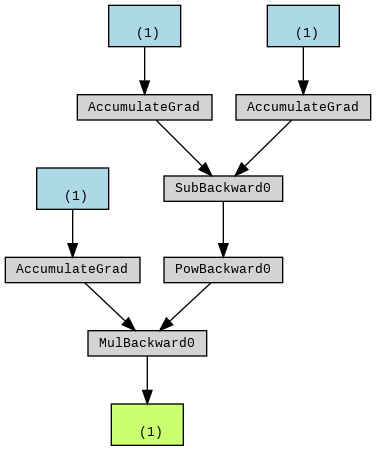

##Gráfica dinámica

Graficquemos la misma función (
b
=
x
(
y
−
z
)
**2
)

En este caso, podemos ver que los argumentos de entrada se asignan inmediatamente a los valores de los argumentos que va a tomar la gráfica.

Las operaciones, de igual forma, se computan de manera inmediata con los valores de los argumentos. Es decir, no necesitamos definir un diccionario de valores, pues estos fluyen de manera inmediata. Podríamos pensar que las operaciones se realizan en el flujo de la información en las aristas; no es necesario ejecutar una orden de correor run.

El paso backward es muy simple, pues sólo falta indicar al valor de salida
b
, que compute el backward por medio del método .backward(). En este caso, lo que la gráfica hace es que, una vez computado los valores en cada nodo, corre la gráfica en sentido inverso para obtener las derivadas, las cuales se guardan en los mismos nodos (aquellos a los que se ha indicado que requieren gradiente requires_grad=True); es decir, los nodos tiene los valores tanto del paso forward como del backward.

Al final, sólo accedemos al gradiente de ese nodo por medio de .grad.

In [10]:
!pip install torchviz
import torch
from torchviz import make_dot

def dynamic(x1, x2, x3):
    # Inicializa los tensores de entrada
    x = torch.tensor(x1, requires_grad=True)
    y = torch.tensor(x2, requires_grad=True)
    z = torch.tensor(x3, requires_grad=True)

    # Define el paso forward
    a = y - z
    b = x * a**2

    # Cómputa el backward
    b.backward()

    # Guarda las derivadas
    dx, dy, dz = x.grad, y.grad, z.grad

    print('Salida: {}'.format(b))
    print('Valores de gradiente: [{} {} {}]'.format(dx, dy, dz))

    # Visualiza la gráfica computacional
    dot = make_dot(b, params={'x': x, 'y': y, 'z': z})
    dot.render("graph", format="png")  # Guarda la gráfica como un archivo PNG

dynamic(2.0, 5.0, 3.0)

Salida: 8.0
Valores de gradiente: [4.0 8.0 -8.0]


* Estático: Grafo definido antes de la ejecución, mejor rendimiento, menos flexibilidad.

* Dinámico: Grafo construido en tiempo de ejecución, más flexible, permite condiciones y cambios durante la ejecución.


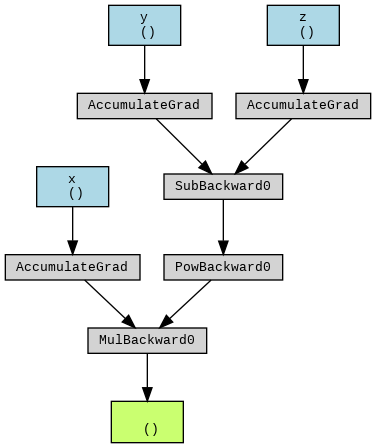

##Ejercicio

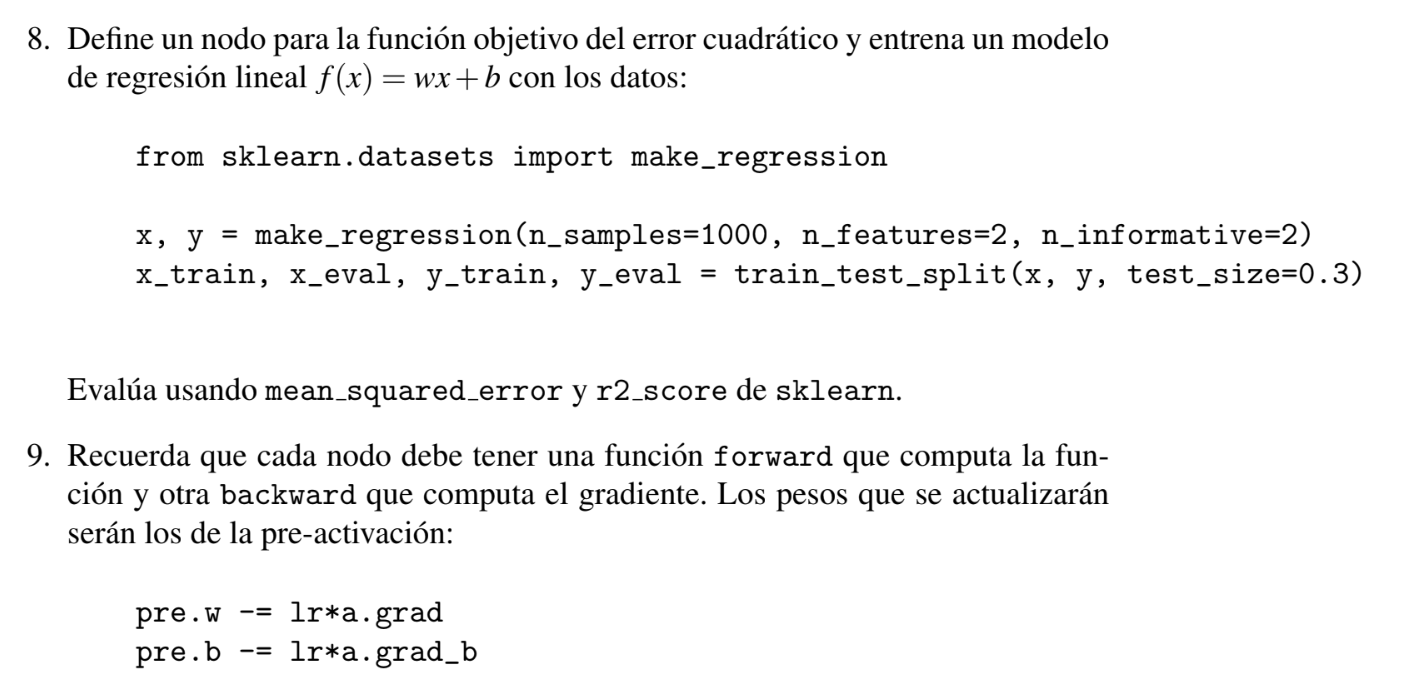

In [13]:
import torch
from torchviz import make_dot
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Definición de la clase para el nodo de la regresión lineal
class LinearRegressionNode:
    def __init__(self):
        self.w = torch.randn(2, requires_grad=True)  # Pesos
        self.b = torch.randn(1, requires_grad=True)  # Sesgo

    def forward(self, x):
        return torch.matmul(x, self.w) + self.b

    def backward(self, y_pred, y_true):
        # Calcular la pérdida (mean squared error)
        loss = ((y_pred - y_true) ** 2).mean()
        loss.backward()  # Calcula los gradientes
        return loss

# Función para entrenar el modelo
def train_model(x_train, y_train, learning_rate=0.01, epochs=100):
    model = LinearRegressionNode()


    return model

# Generación de datos
x, y = make_regression(n_samples=1000, n_features=2, n_informative=2, noise=0.1)
x_train, x_eval, y_train, y_eval = train_test_split(x, y, test_size=0.3)



Epoch [10/100], Loss: 7264.9673
Epoch [20/100], Loss: 4947.1313
Epoch [30/100], Loss: 3369.6460
Epoch [40/100], Loss: 2295.7500
Epoch [50/100], Loss: 1564.4915
Epoch [60/100], Loss: 1066.4208
Epoch [70/100], Loss: 727.0930
Epoch [80/100], Loss: 495.8565
Epoch [90/100], Loss: 338.2401
Epoch [100/100], Loss: 230.7794
Mean Squared Error: 263.7103
R^2 Score: 0.9773


'linear_regression_graph.png'

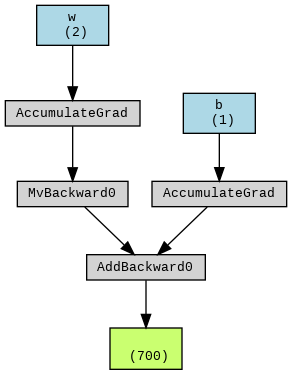